In [13]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing import timeseries_dataset_from_array
#from google.colab import drive
#drive.mount('/content/drive')
path = 'archive/ETH_1min.csv'


class DataPreprocess:
    def __init__(self):
        pass

    def load_data(self, path):
        df = pd.read_csv(path)
        df.drop("Unnamed: 0", inplace=True, axis = 1)
        #df.drop("system_time", inplace=True, axis = 1)
        return df

    def get_bid_levels(self, df, bid_levels):
        df_tmp = pd.DataFrame()
        df_tmp['time'] = df['system_time']
        df_tmp['midpoint'] = df['midpoint']

        # Filter ask and bid volume columns
        ask_cols = [f'asks_limit_notional_{i}' for i in range(bid_levels)]
        bid_cols = [f'bids_limit_notional_{i}' for i in range(bid_levels)]
        ask_cols = [col for col in ask_cols if col in df.columns]
        bid_cols = [col for col in bid_cols if col in df.columns]

        # Assign ask and bid volumes
        for lvls in range(len(ask_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_volume{lvls}'] = df[ask_cols[lvls]]
        for lvls in range(len(bid_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_volume{lvls}'] = df[bid_cols[lvls]]

        # Filter ask and bid distance columns
        ask_distance_cols = [f'asks_distance_{i}' for i in range(bid_levels)]
        bid_distance_cols = [f'bids_distance_{i}' for i in range(bid_levels)]
        ask_distance_cols = [col for col in ask_distance_cols if col in df.columns]
        bid_distance_cols = [col for col in bid_distance_cols if col in df.columns]

        # Assign ask and bid prices
        for lvls in range(len(ask_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[ask_distance_cols[lvls]])
        for lvls in range(len(bid_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[bid_distance_cols[lvls]])
        return df_tmp



In [15]:
dp = DataPreprocess()

df = dp.load_data(path)

num_levels = 10
df = dp.get_bid_levels(df, num_levels)

In [17]:
df.head()

,time,midpoint,ask_volume0,ask_volume1,ask_volume2,ask_volume3,ask_volume4,ask_volume5,ask_volume6,ask_volume7,...,bid_price0,bid_price1,bid_price2,bid_price3,bid_price4,bid_price5,bid_price6,bid_price7,bid_price8,bid_price9
0,2021-04-07 11:33:49.861733+00:00,1965.845,20005.570312,3234.250000,2.000531e+04,4350.029785,5839.970215,20005.439453,3874.320068,731.830017,...,1965.84,1965.54,1965.53,1965.34,1965.33,1965.30,1965.01,1965.00,1964.95,1964.85
1,2021-04-07 11:34:49.861733+00:00,1969.645,36921.578125,29840.800781,1.003755e+06,3873.060059,20216.859375,20009.779297,20004.830078,733.619995,...,1969.32,1969.27,1969.25,1969.24,1969.22,1969.14,1969.12,1969.11,1969.06,1969.05
2,2021-04-07 11:35:49.861733+00:00,1975.595,13438.839844,3873.080078,6.975460e+03,21856.339844,28646.380859,3873.739990,26095.470703,743.140015,...,1975.45,1975.44,1975.41,1975.40,1975.21,1975.06,1975.04,1974.96,1974.94,1974.57
3,2021-04-07 11:36:49.861733+00:00,1969.335,2028.510010,31570.119141,2.204419e+04,4873.629883,19998.630859,7077.069824,985.219971,20004.689453,...,1969.24,1969.01,1969.00,1968.96,1968.79,1968.59,1968.58,1968.48,1968.47,1968.46
4,2021-04-07 11:37:49.861733+00:00,1970.965,1163.010010,1163.020020,3.769630e+03,21908.570312,4873.000000,77911.609375,79081.539062,50146.808594,...,1970.72,1970.71,1970.57,1970.48,1970.45,1970.38,1970.34,1970.07,1969.97,1969.96


In [19]:
from tensorflow.keras.utils import timeseries_dataset_from_array
import numpy as np

# Set window size
window_size = 40

# Function to create normalized data
def normalize_data(df, train_length):
    """
    Normalizes data based on the training dataset mean and std.
    """
    mean_df = df[:train_length].mean()
    std_df = df[:train_length].std()
    normalized_df = (df - mean_df) / std_df
    return normalized_df

# Drop time column (not needed for input features)
df = df.drop(columns=["time"])

# Split dataset into train and test sets
data_length = df.shape[0]
train_length = round(0.8 * data_length)  # 80% training data
normalized_df = normalize_data(df, train_length)

data_array = normalized_df.to_numpy()

X = data_array[:, 1:]  # All columns except the first ('midpoint')
y = data_array[:, 0]   # The first column is 'midpoint'

windows_train = timeseries_dataset_from_array(
    X[:train_length],                    # Features for training
    y[window_size:(train_length+window_size)],  # Target (midpoint) for training
    sequence_length=window_size,        # Length of each input sequence
    sequence_stride=1,                  # Step size for creating sequences
    sampling_rate=1,                    # Sample every time step
    batch_size=64,                      # Batch size
    shuffle=True                        # Shuffle training data
)

# Windows for test dataset
windows_test = timeseries_dataset_from_array(
    X[train_length:(data_length-window_size)],  # Features for testing
    y[train_length + window_size:],            # Target (midpoint) for testing
    sequence_length=window_size,               # Length of each input sequence
    sequence_stride=1,                         # Step size for creating sequences
    sampling_rate=1,                           # Sample every time step
    batch_size=64,                             # Batch size
    shuffle=False                              # Do not shuffle test data
)

In [21]:
df.head()

,midpoint,ask_volume0,ask_volume1,ask_volume2,ask_volume3,ask_volume4,ask_volume5,ask_volume6,ask_volume7,ask_volume8,...,bid_price0,bid_price1,bid_price2,bid_price3,bid_price4,bid_price5,bid_price6,bid_price7,bid_price8,bid_price9
0,1965.845,20005.570312,3234.250000,2.000531e+04,4350.029785,5839.970215,20005.439453,3874.320068,731.830017,373.700012,...,1965.84,1965.54,1965.53,1965.34,1965.33,1965.30,1965.01,1965.00,1964.95,1964.85
1,1969.645,36921.578125,29840.800781,1.003755e+06,3873.060059,20216.859375,20009.779297,20004.830078,733.619995,3873.709961,...,1969.32,1969.27,1969.25,1969.24,1969.22,1969.14,1969.12,1969.11,1969.06,1969.05
2,1975.595,13438.839844,3873.080078,6.975460e+03,21856.339844,28646.380859,3873.739990,26095.470703,743.140015,988.309998,...,1975.45,1975.44,1975.41,1975.40,1975.21,1975.06,1975.04,1974.96,1974.94,1974.57
3,1969.335,2028.510010,31570.119141,2.204419e+04,4873.629883,19998.630859,7077.069824,985.219971,20004.689453,68366.406250,...,1969.24,1969.01,1969.00,1968.96,1968.79,1968.59,1968.58,1968.48,1968.47,1968.46
4,1970.965,1163.010010,1163.020020,3.769630e+03,21908.570312,4873.000000,77911.609375,79081.539062,50146.808594,2085.110107,...,1970.72,1970.71,1970.57,1970.48,1970.45,1970.38,1970.34,1970.07,1969.97,1969.96


In [23]:
def extract_data_from_windows(windows):
    """
    Extracts features and targets from a TensorFlow dataset object.
    """
    X_list = []
    y_list = []
    for X_batch, y_batch in windows:
        X_list.append(X_batch.numpy())
        y_list.append(y_batch.numpy())
    X_array = np.vstack(X_list)  # Stack all batches into a single array
    y_array = np.concatenate(y_list)
    return X_array, y_array

# Extract features and targets for training and testing
X_train, y_train = extract_data_from_windows(windows_train)
X_test, y_test = extract_data_from_windows(windows_test)


2024-12-08 15:12:00.909619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:12:01.298159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
X_train.shape

(13649, 40, 40)

In [27]:
from sklearn.preprocessing import StandardScaler
# Flatten the features for training and testing
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten (num_samples, window_size, num_features) -> (num_samples, window_size*num_features)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train_flat)

# Transform testing data
X_test_scaled = scaler.transform(X_test_flat)



In [29]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [31]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten

input_layer = Input(shape = (X_train_scaled.shape[1], 1))
conv_layer = Conv1D(filters = 1 , kernel_size = 10, strides = 10 , activation = 'linear')(input_layer)
conv_layer = Conv1D(filters= 1, kernel_size = 10, padding='same', activation='linear')(conv_layer)
flatten_layer = Flatten()(conv_layer)
full_model = Model(inputs = input_layer, outputs = flatten_layer)


In [33]:
X_train_features = full_model.predict(X_train_scaled)
X_test_features = full_model.predict(X_test_scaled)

427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [35]:
import tensorflow as tf

def custom_svr_loss(y_true, y_pred, epsilon=0.01, mu=1.0):
    """
    Custom SVR loss with direction sensitivity.
    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.
        epsilon: Epsilon margin for insensitive loss.
        mu: Scaling factor for the direction penalty.
    """
    # Epsilon-insensitive loss
    abs_error = tf.abs(y_true - y_pred)
    baseline_loss = tf.maximum(0.0, abs_error - epsilon)

    # Direction-sensitive penalty
    delta_y = y_true - tf.reduce_mean(y_true)
    delta_y_pred = y_pred - tf.reduce_mean(y_pred)
    theta_y = tf.atan(delta_y)
    theta_y_pred = tf.atan(delta_y_pred)
    angular_diff = (tf.abs(theta_y - theta_y_pred) / (tf.constant(np.pi) / 2))
    direction_loss = mu * angular_diff * abs_error


    total_loss = tf.reduce_mean(baseline_loss + direction_loss)
    # total_loss = (baseline_loss + direction_loss)
    return total_loss


In [37]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input dimensions are based on the embedding size
input_dim = X_train_features.shape[1]

# Define the SVR-like model
svr_input = Input(shape=(input_dim,))
svr_output = Dense(1, activation='linear')(svr_input)

svr_model = Model(inputs=svr_input, outputs=svr_output)

# Compile the model with the custom loss function
svr_model.compile(optimizer=Adam(learning_rate=0.01),
                  loss=lambda y_true, y_pred: custom_svr_loss(y_true, y_pred, epsilon= 0.98 , mu= 0.98))


In [39]:
# Train the SVR model
history_svr = svr_model.fit(
    X_train_features, y_train,  # Training embeddings and targets
    validation_data=(X_test_features, y_test),  # Validation embeddings and targets
    epochs=50,  # Number of epochs
    batch_size=64,  # Batch size
    verbose=1  # Verbosity level
)


Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2123 - val_loss: 0.0060
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0061
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - val_loss: 0.0305
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0080
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0064
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0099
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - val_loss: 0.0113
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.0045
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 12/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def calculate_metrics_and_plot(svr_model1, lvl):
    data_preprocessor = DataPreprocess()
    
    # Step 2: Load the CSV file
    file_path = "archive/ETH_1min.csv"  # Path to the CSV file
    df2 = data_preprocessor.load_data(file_path)
    
    # Step 3: Process the data for 10 bid/ask levels
    eth_df = data_preprocessor.get_bid_levels(df2, bid_levels=lvl)
    eth_df.drop("time", inplace = True, axis = 1)
    eth_df.head()
    
    mean_df = eth_df[:train_length].mean()
    std_df = eth_df[:train_length].std()
    
    normalized_df = (eth_df - mean_df) / std_df
    # Predict
    y_pred = svr_model1.predict(X_test_features)
    
    # Remove standardization from predictions
    real_pred = y_pred.flatten() * std_df["midpoint"] + mean_df["midpoint"]
    
    # Prepare true values for comparison
    input_pred = eth_df["midpoint"][train_length + window_size:].reset_index(drop=True)
    
    # Align lengths
    min_length = min(len(input_pred), len(real_pred))
    real_pred = real_pred[:min_length]
    input_pred = input_pred[:min_length]
    
    # Calculate metrics
    mse = mean_squared_error(input_pred, real_pred)
    r2 = r2_score(input_pred, real_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")
    
    # Plot
    plt.plot(real_pred, label="Prediction")
    plt.plot(input_pred, label="True Price")
    plt.legend(loc="upper right")
    plt.show()

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean Squared Error: 114.99359663886834
R² Score: 0.9919611442532817


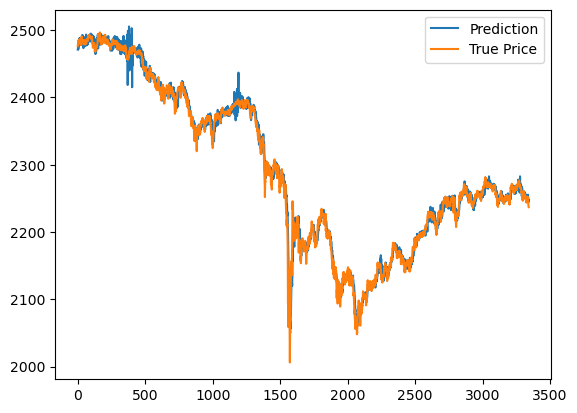

In [47]:
calculate_metrics_and_plot(svr_model, 10)

In [58]:
def get_bid_with_ofi_levels(df_tmp, bid_levels):
    for lvls in range(bid_levels):
        bid_price = df_tmp[f'bid_price{lvls}']
        ask_price = df_tmp[f'ask_price{lvls}']
        bid_volume = df_tmp[f'bid_volume{lvls}']
        ask_volume = df_tmp[f'ask_volume{lvls}']
        
        # Shift prices and volumes to compute differences
        bid_price_prev = bid_price.shift(1)
        ask_price_prev = ask_price.shift(1)
        bid_volume_prev = bid_volume.shift(1)
        ask_volume_prev = ask_volume.shift(1)
        
        # Calculate bid and ask order flows
        bid_of = np.where(
            bid_price > bid_price_prev, bid_volume,
            np.where(bid_price == bid_price_prev, bid_volume - bid_volume_prev, -bid_volume)
        )
        ask_of = np.where(
            ask_price > ask_price_prev, -ask_volume,
            np.where(ask_price == ask_price_prev, ask_volume - ask_volume_prev, ask_volume)
        )
        
        # Calculate OFI
        df_tmp[f'ofi_level{lvls}'] = bid_of - ask_of
    return df_tmp

Computing for iteration -  3 ofi - False lvl - 3 window size 25


2024-12-08 15:29:34.833458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:29:35.062358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2740 - val_loss: 0.0159
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0260 - val_loss: 0.0137
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - val_loss: 0.0131
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0223 - val_loss: 0.0131
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0225 - val_loss: 0.0131
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0207 - val_loss: 0.0134
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - val_loss: 0.0136
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - val_loss: 0.0143
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0229 - val_loss: 0.0132
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0217 - val_loss: 0.0143
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

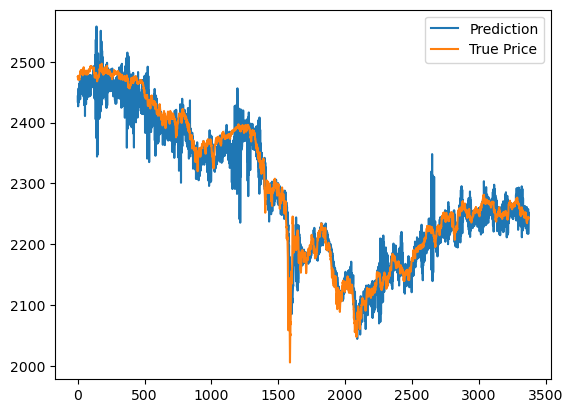

Computing for iteration -  2 ofi - False lvl - 3 window size 25


2024-12-08 15:30:13.976120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:30:14.305919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0628 - val_loss: 0.0078
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0096 - val_loss: 0.0072
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0074
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0088 - val_loss: 0.0081
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

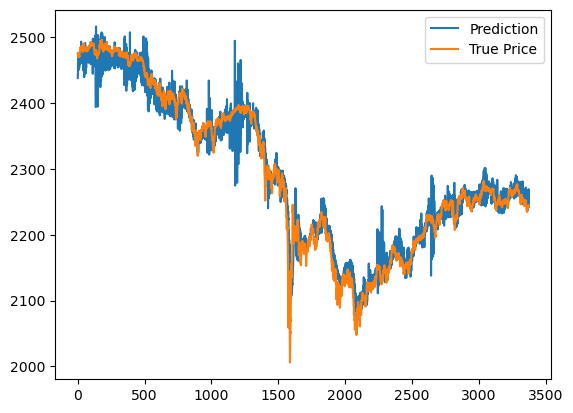

Computing for iteration -  1 ofi - False lvl - 3 window size 25


2024-12-08 15:30:51.389394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:30:51.709073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4217 - val_loss: 0.0578
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1636 - val_loss: 0.0600
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1557 - val_loss: 0.0591
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1549 - val_loss: 0.0594
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1586 - val_loss: 0.0578
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1598 - val_loss: 0.0569
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1573 - val_loss: 0.0590
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1638 - val_loss: 0.0581
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1517 - val_loss: 0.0586
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1508 - val_loss: 0.0594
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

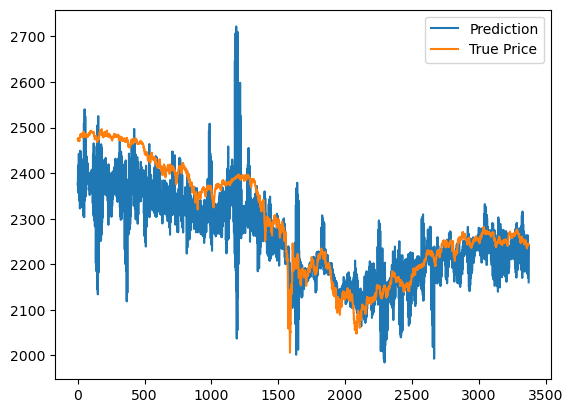

Computing for iteration -  3 ofi - True lvl - 3 window size 25


2024-12-08 15:31:26.940193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:31:27.199337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6820 - val_loss: 0.0157
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0303 - val_loss: 0.0121
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0229 - val_loss: 0.0118
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - val_loss: 0.0117
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0116
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0230 - val_loss: 0.0120
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.0129
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0224 - val_loss: 0.0117
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0228 - val_loss: 0.0116
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0233 - val_loss: 0.0115
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

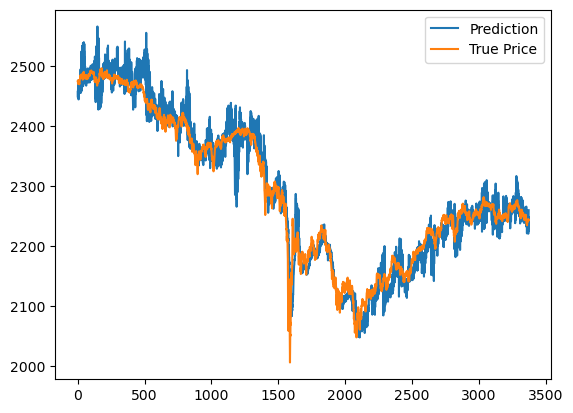

Computing for iteration -  2 ofi - True lvl - 3 window size 25


2024-12-08 15:32:03.133571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:32:03.443392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1410 - val_loss: 0.0080
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0069
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0077
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0067
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0071
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0095 - val_loss: 0.0070
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - val_loss: 0.0080
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

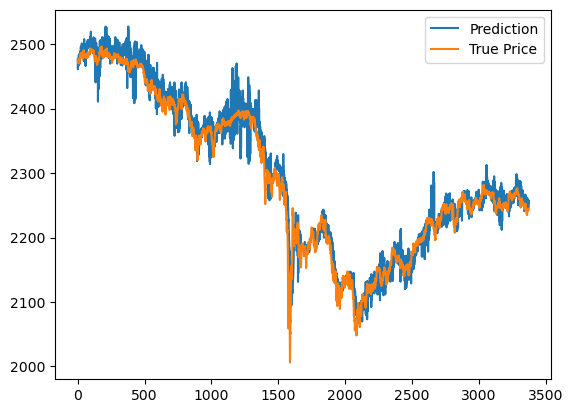

Computing for iteration -  1 ofi - True lvl - 3 window size 25


2024-12-08 15:32:40.479641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:32:40.756849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1243 - val_loss: 0.0082
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_loss: 0.0069
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0069
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0067
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087 - val_loss: 0.0068
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

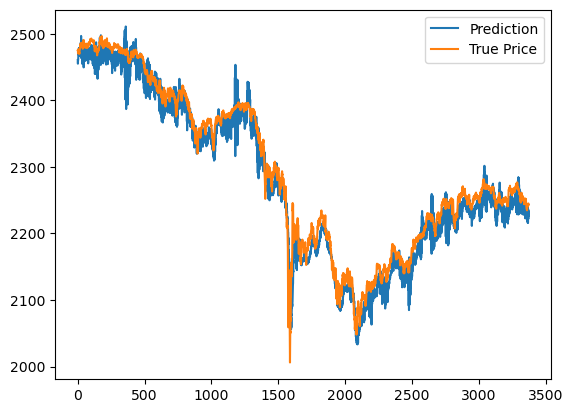

Computing for iteration -  3 ofi - False lvl - 5 window size 25


2024-12-08 15:33:18.420718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:33:18.708038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1003 - val_loss: 0.0079
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0068
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0055
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8078e-04 - val_loss: 0.0036
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.0750e-04 - val_loss: 0.0028
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.6038e-04 - val_loss: 0.0024
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5758e-04 - val_loss: 0.0021
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5766e-04 - val_loss: 0.0019
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4228e-04 - val_loss: 0.0015
Epoch 11/50
214/214 ━━━━━━━━━━━━━

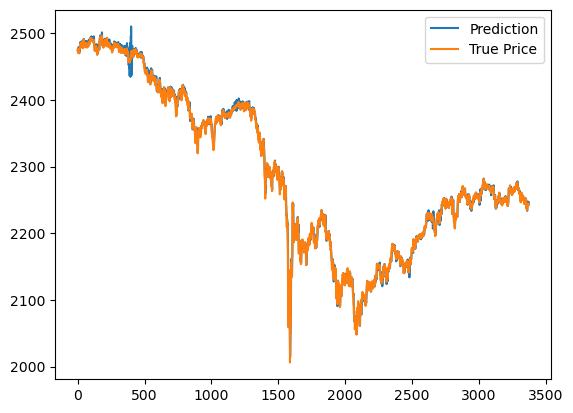

Computing for iteration -  2 ofi - False lvl - 5 window size 25


2024-12-08 15:33:52.688872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:33:52.979175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1027 - val_loss: 0.0048
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3863e-04 - val_loss: 0.0044
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0708e-04 - val_loss: 0.0040
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1403e-04 - val_loss: 0.0037
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2477e-04 - val_loss: 0.0030
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7511e-04 - val_loss: 0.0027
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.5891e-04 - val_loss: 0.0032
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 11/50
214/214 ━━━━━━━━━━━━━

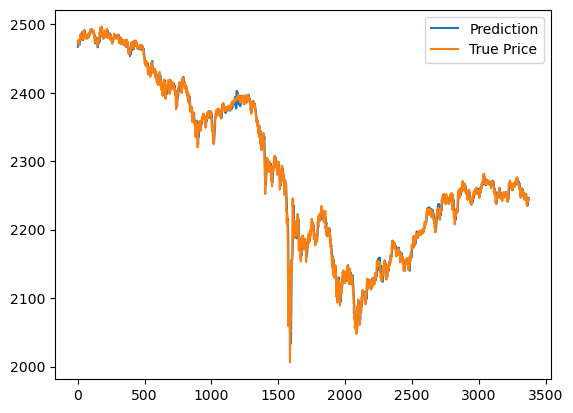

Computing for iteration -  1 ofi - False lvl - 5 window size 25


2024-12-08 15:34:35.572360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:34:36.430900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0730 - val_loss: 0.0047
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0349e-04 - val_loss: 0.0045
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.8283e-04 - val_loss: 0.0042
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7716e-04 - val_loss: 0.0037
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.4820e-04 - val_loss: 0.0034
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.8547e-04 - val_loss: 0.0031
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3350e-04 - val_loss: 0.0027
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4667e-04 - val_loss: 0.0025
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.0783e-04 - val_loss: 0.0023
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7469e-04 - val_loss: 0.0021
Epoch 11/50
214/214 ━

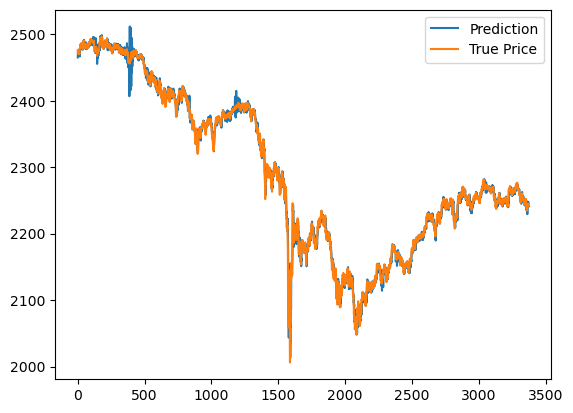

Computing for iteration -  3 ofi - True lvl - 5 window size 25


2024-12-08 15:35:14.322026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:35:14.588706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1493 - val_loss: 0.0045
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9374e-04 - val_loss: 0.0023
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8155e-04 - val_loss: 0.0023
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.8462e-04 - val_loss: 0.0022
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6554e-04 - val_loss: 0.0022
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4649e-04 - val_loss: 0.0020
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1186e-04 - val_loss: 0.0021
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9212e-04 - val_loss: 0.0020
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0778e-04 - val_loss: 0.0020
Epoch 11/50
214/214 ━━━━━

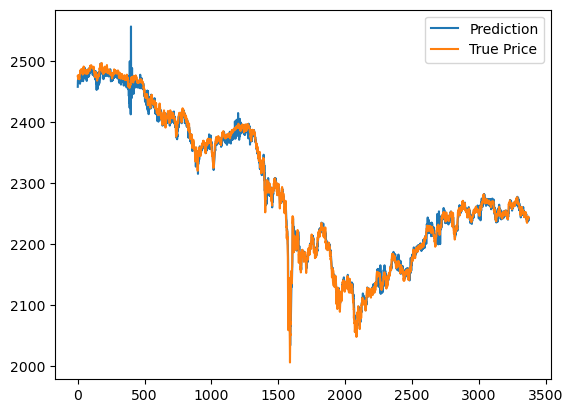

Computing for iteration -  2 ofi - True lvl - 5 window size 25


2024-12-08 15:35:47.188340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:35:47.462060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3044 - val_loss: 0.0096
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0070
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

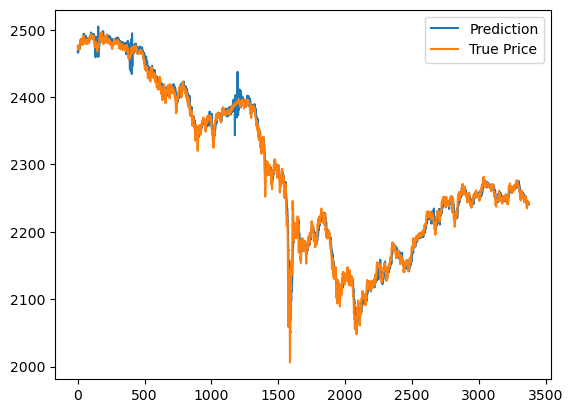

Computing for iteration -  1 ofi - True lvl - 5 window size 25


2024-12-08 15:36:25.616004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:36:26.001593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1208 - val_loss: 0.0045
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3205e-04 - val_loss: 0.0028
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1451e-04 - val_loss: 0.0025
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5630e-04 - val_loss: 0.0023
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4739e-04 - val_loss: 0.0022
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9761e-04 - val_loss: 0.0020
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8239e-04 - val_loss: 0.0018
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.4617e-04 - val_loss: 0.0017
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2901e-04 - val_loss: 0.0015
Epoch 11/50
214/214 ━━━━━

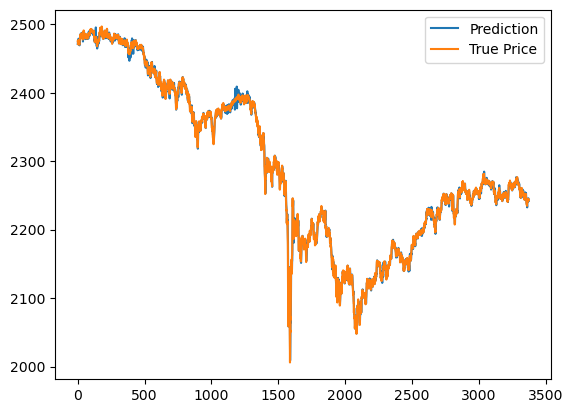

Computing for iteration -  3 ofi - False lvl - 10 window size 25


2024-12-08 15:37:00.496646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:37:00.911011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2576 - val_loss: 0.0090
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5104e-04 - val_loss: 0.0031
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7530e-04 - val_loss: 0.0032
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2357e-04 - val_loss: 0.0032
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8085e-04 - val_loss: 0.0033
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5853e-04 - val_loss: 0.0040
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0077
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━

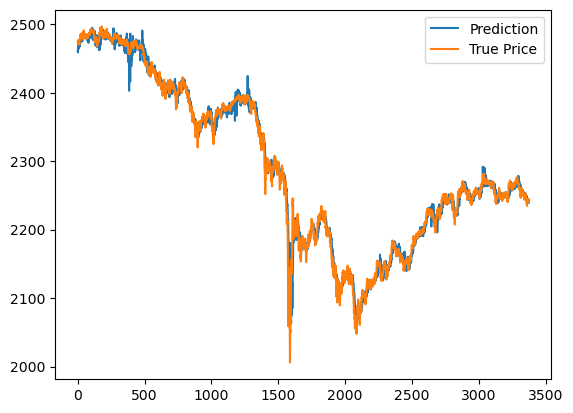

Computing for iteration -  2 ofi - False lvl - 10 window size 25


2024-12-08 15:37:26.807465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:37:27.077483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2156 - val_loss: 0.0039
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9838e-04 - val_loss: 0.0038
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5547e-04 - val_loss: 0.0037
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6086e-04 - val_loss: 0.0042
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0036
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6458e-04 - val_loss: 0.0034
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 

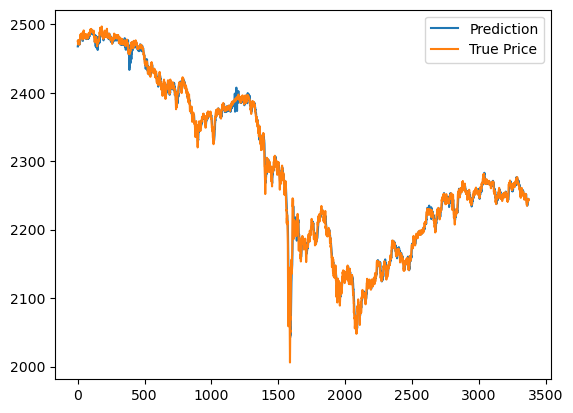

Computing for iteration -  1 ofi - False lvl - 10 window size 25


2024-12-08 15:37:53.399891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:37:53.669482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5851 - val_loss: 0.0141
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4691e-04 - val_loss: 0.0034
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8421e-04 - val_loss: 0.0030
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7749e-04 - val_loss: 0.0029
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1974e-04 - val_loss: 0.0026
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6772e-04 - val_loss: 0.0024
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3791e-04 - val_loss: 0.0022
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1784e-04 - val_loss: 0.0020
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0843e-04 - val_loss: 0.0020
Epoch 11/50
214/214 ━━━━━

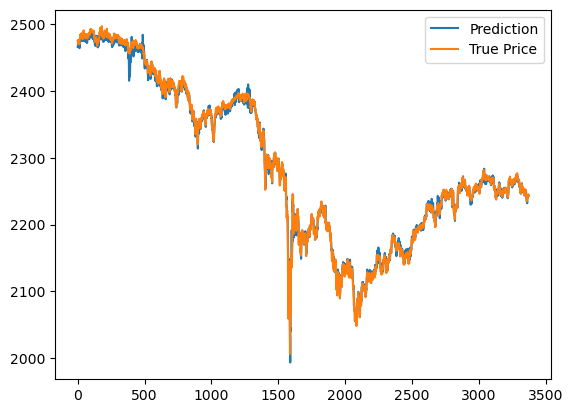

Computing for iteration -  3 ofi - True lvl - 10 window size 25


2024-12-08 15:38:26.880608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:38:27.298197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1503 - val_loss: 0.0047
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0089
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - val_loss: 0.0058
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0182
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0285 - val_loss: 0.0074
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0097 - val_loss: 0.0052
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

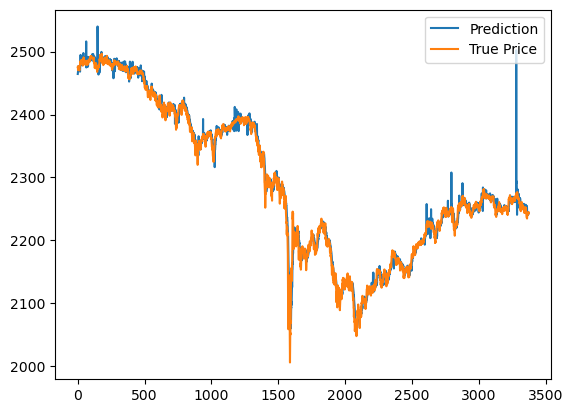

Computing for iteration -  2 ofi - True lvl - 10 window size 25


2024-12-08 15:39:01.661883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:39:02.030757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3968 - val_loss: 0.0152
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.2309e-04 - val_loss: 0.0022
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.1547e-04 - val_loss: 0.0016
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8615e-04 - val_loss: 0.0014
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9175e-04 - val_loss: 0.0013
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7975e-04 - val_loss: 0.0012
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4618e-04 - val_loss: 0.0014
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9345e-04 - val_loss: 0.0013
Epoch 11/50
214/214 ━━━━━━━━━

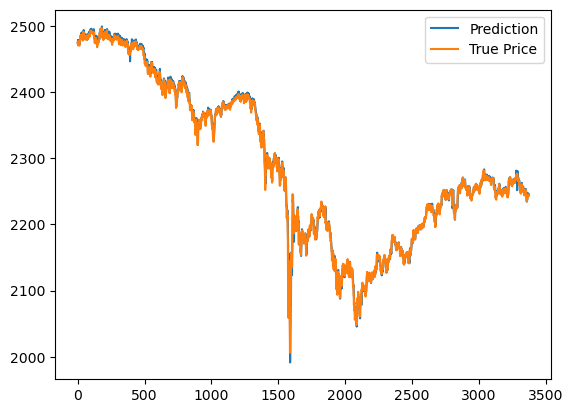

Computing for iteration -  1 ofi - True lvl - 10 window size 25


2024-12-08 15:39:33.764409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:39:34.086061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2334 - val_loss: 0.0079
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0255e-04 - val_loss: 0.0043
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5262e-04 - val_loss: 0.0033
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6279e-04 - val_loss: 0.0035
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5509e-04 - val_loss: 0.0026
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5422e-04 - val_loss: 0.0041
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0303
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0397 - val_loss: 0.0289
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - val_loss: 0.0015
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━

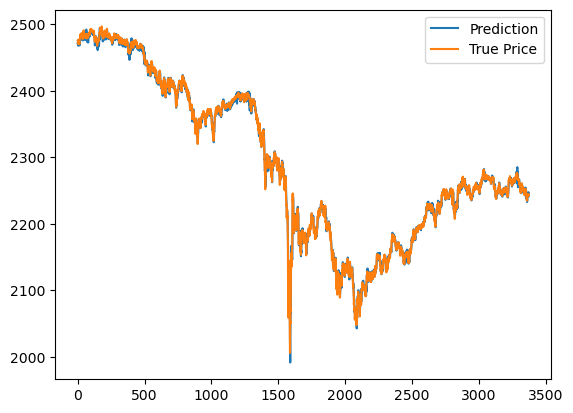

Computing for iteration -  3 ofi - False lvl - 3 window size 50


2024-12-08 15:40:03.029203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:40:03.280480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2242 - val_loss: 0.0133
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0112
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0112
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - val_loss: 0.0108
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0124
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.0123
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

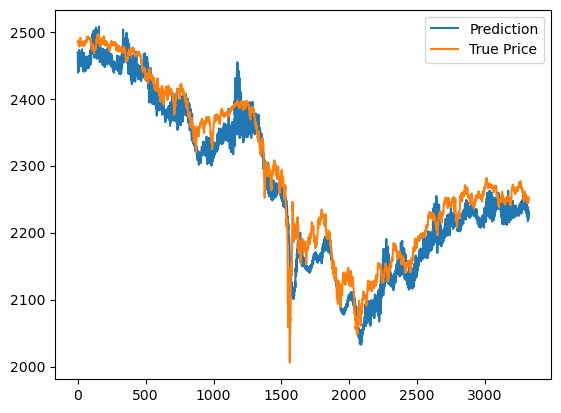

Computing for iteration -  2 ofi - False lvl - 3 window size 50


2024-12-08 15:40:34.173576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:40:34.447306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4504 - val_loss: 0.0105
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - val_loss: 0.0078
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0048 - val_loss: 0.0074
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0082
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0052 - val_loss: 0.0079
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - val_loss: 0.0081
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - val_loss: 0.0081
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0053 - val_loss: 0.0075
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

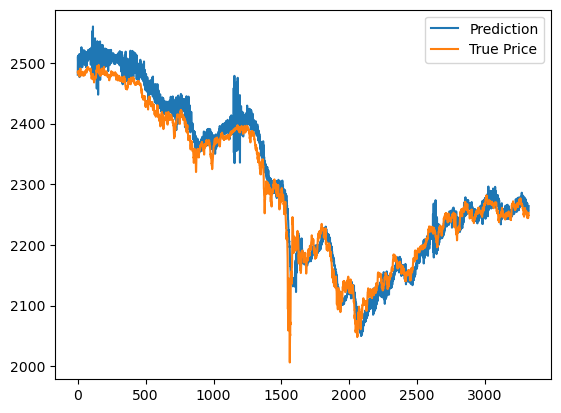

Computing for iteration -  1 ofi - False lvl - 3 window size 50


2024-12-08 15:41:09.904579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:41:10.166504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1592 - val_loss: 0.0106
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - val_loss: 0.0087
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0090
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0084
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

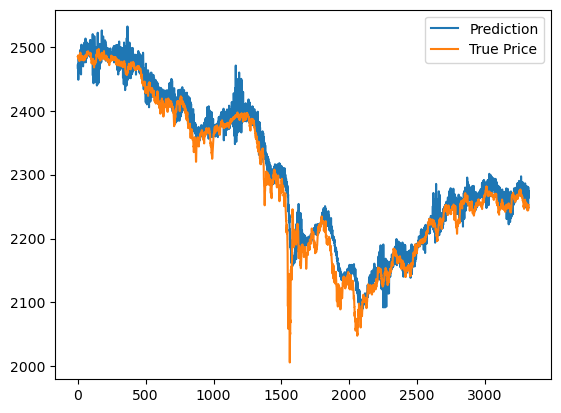

Computing for iteration -  3 ofi - True lvl - 3 window size 50


2024-12-08 15:41:44.444707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:41:44.737593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1072 - val_loss: 0.0121
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - val_loss: 0.0115
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0149 - val_loss: 0.0115
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0114
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0125
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0124
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0150 - val_loss: 0.0118
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151 - val_loss: 0.0154
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - val_loss: 0.0128
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

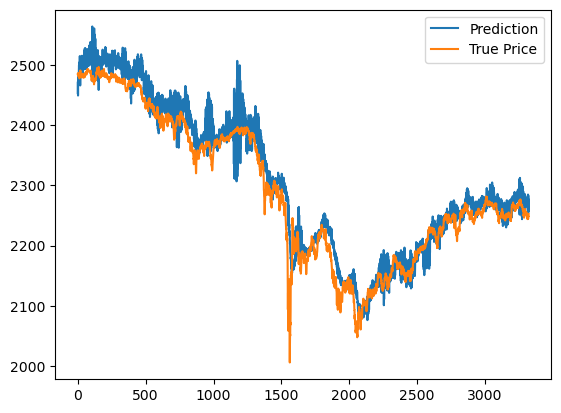

Computing for iteration -  2 ofi - True lvl - 3 window size 50


2024-12-08 15:42:19.106084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:42:19.368767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1090 - val_loss: 0.0092
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - val_loss: 0.0095
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0107
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0083
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103 - val_loss: 0.0116
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0167
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0340 - val_loss: 0.0107
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087 - val_loss: 0.0091
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

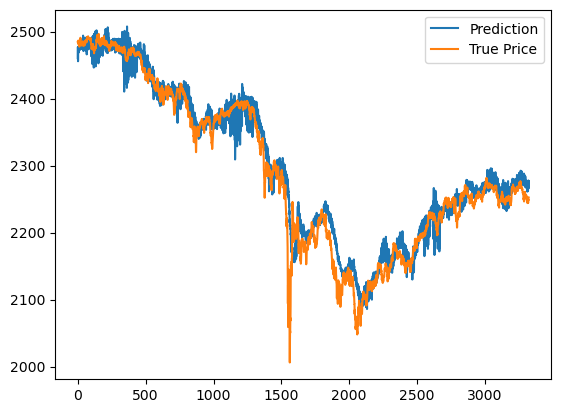

Computing for iteration -  1 ofi - True lvl - 3 window size 50


2024-12-08 15:42:50.159039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:42:50.456126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5013 - val_loss: 0.0558
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1686 - val_loss: 0.0556
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1686 - val_loss: 0.0586
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1787 - val_loss: 0.0545
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1666 - val_loss: 0.0558
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1689 - val_loss: 0.0604
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1853 - val_loss: 0.0571
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1836 - val_loss: 0.0547
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1700 - val_loss: 0.0525
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1692 - val_loss: 0.0551
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

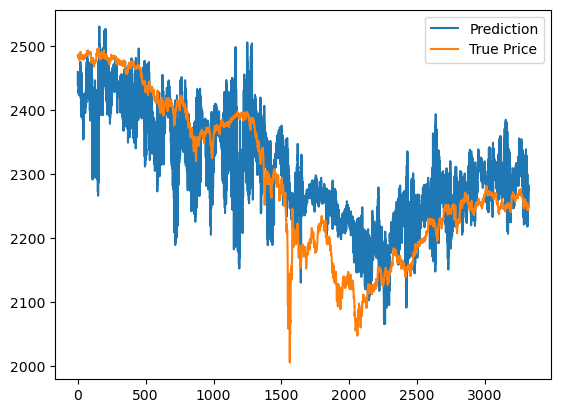

Computing for iteration -  3 ofi - False lvl - 5 window size 50


2024-12-08 15:43:22.426666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:43:22.704206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5002 - val_loss: 0.0113
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0074
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0063
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0761e-04 - val_loss: 0.0053
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3070e-04 - val_loss: 0.0048
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6971e-04 - val_loss: 0.0041
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8150e-04 - val_loss: 0.0037
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6300e-04 - val_loss: 0.0033
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1534e-04 - val_loss: 0.0029
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4433e-04 - val_loss: 0.0027
Epoch 11/50
214/214 ━━━━━━━━━

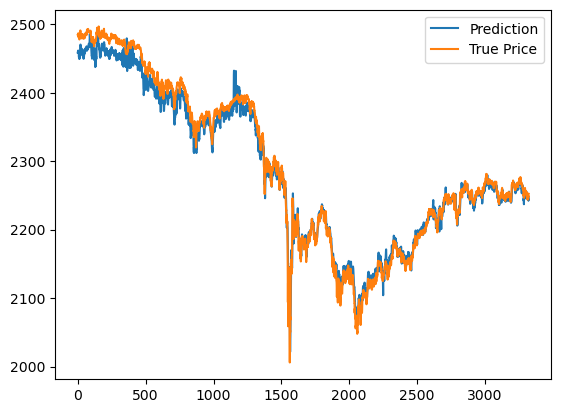

Computing for iteration -  2 ofi - False lvl - 5 window size 50


2024-12-08 15:43:52.684541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:43:52.956049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1655 - val_loss: 0.0057
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0440e-04 - val_loss: 0.0032
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.9009e-04 - val_loss: 0.0029
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.0425e-04 - val_loss: 0.0027
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8612e-04 - val_loss: 0.0028
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3348e-04 - val_loss: 0.0026
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1451e-04 - val_loss: 0.0027
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 11/50
214/214 ━━━━━━━━━━━━━

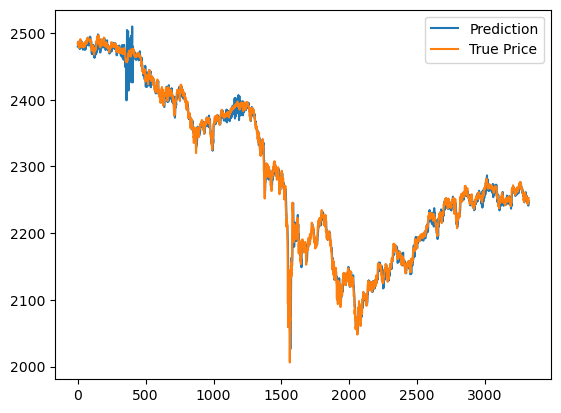

Computing for iteration -  1 ofi - False lvl - 5 window size 50


2024-12-08 15:44:24.233235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:44:24.502496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1780 - val_loss: 0.0062
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0057
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0050
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4444e-04 - val_loss: 0.0045
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3703e-04 - val_loss: 0.0039
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6908e-04 - val_loss: 0.0035
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.8566e-04 - val_loss: 0.0030
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1066e-04 - val_loss: 0.0026
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3728e-04 - val_loss: 0.0024
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7579e-04 - val_loss: 0.0021
Epoch 11/50
214/214 ━━━━━━━━━

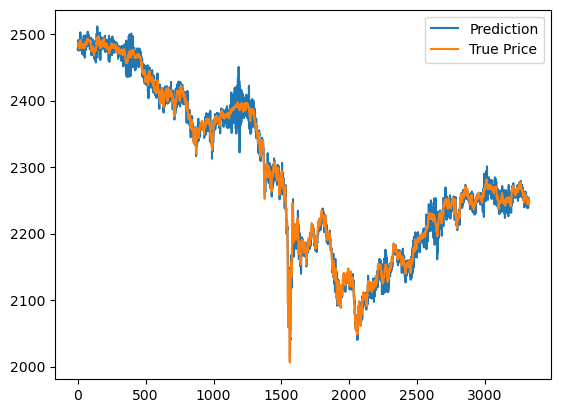

Computing for iteration -  3 ofi - True lvl - 5 window size 50


2024-12-08 15:44:55.671028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:44:56.046027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1664 - val_loss: 0.0128
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0090
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0068
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6068e-04 - val_loss: 0.0035
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4441e-04 - val_loss: 0.0031
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6214e-04 - val_loss: 0.0028
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1296e-04 - val_loss: 0.0028
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4912e-04 - val_loss: 0.0026
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━

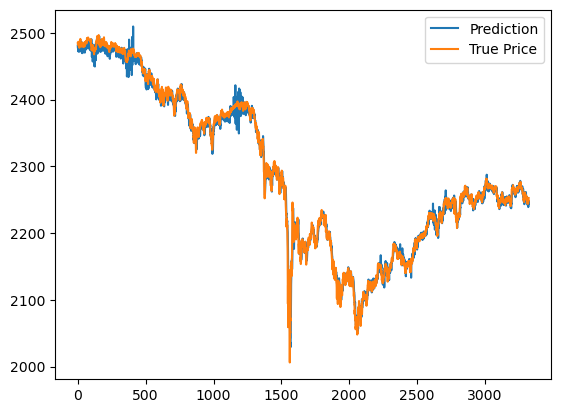

Computing for iteration -  2 ofi - True lvl - 5 window size 50


2024-12-08 15:45:28.743383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:45:29.125475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1885 - val_loss: 0.0072
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - val_loss: 0.0051
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0092
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0308 - val_loss: 0.0041
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

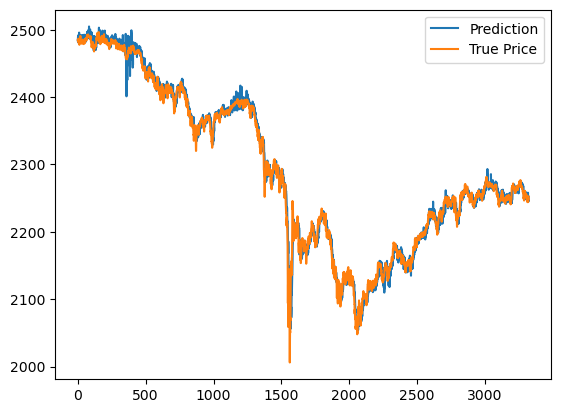

Computing for iteration -  1 ofi - True lvl - 5 window size 50


2024-12-08 15:46:02.236205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:46:02.615933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2650 - val_loss: 0.0128
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062 - val_loss: 0.0071
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0078
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0073
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0068
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0076
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

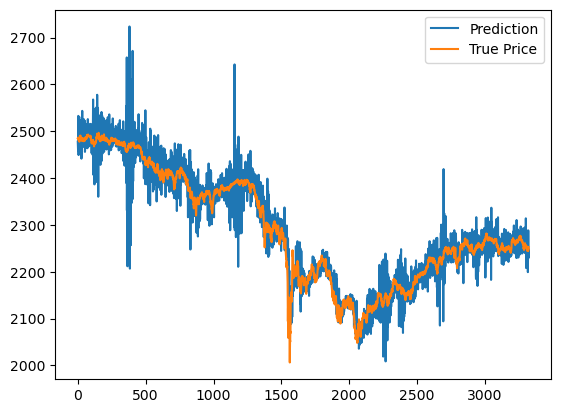

Computing for iteration -  3 ofi - False lvl - 10 window size 50


2024-12-08 15:46:34.083510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:46:34.564175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1523 - val_loss: 0.0085
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036 - val_loss: 0.0460
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1055 - val_loss: 0.0397
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0327 - val_loss: 0.0046
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0184 - val_loss: 0.0394
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0482 - val_loss: 0.0216
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0176
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0033
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

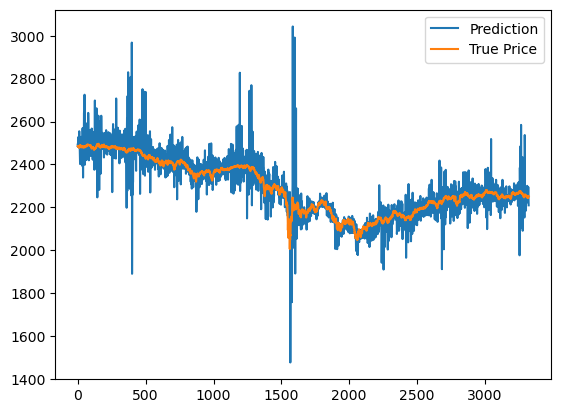

Computing for iteration -  2 ofi - False lvl - 10 window size 50


2024-12-08 15:47:06.694119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:47:07.279228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1385 - val_loss: 0.0088
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0073
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.0294
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0321 - val_loss: 0.0073
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

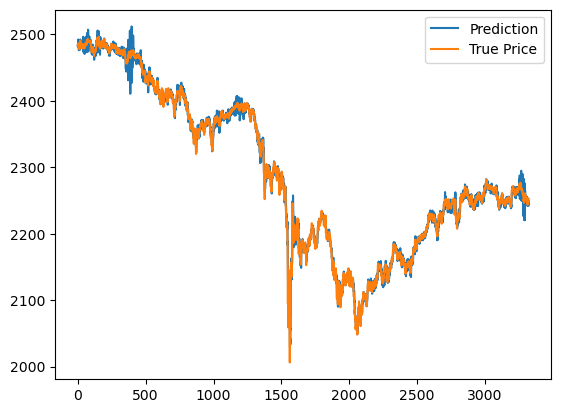

Computing for iteration -  1 ofi - False lvl - 10 window size 50


2024-12-08 15:47:40.000800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:47:40.399464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4170 - val_loss: 0.0088
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3994e-04 - val_loss: 0.0032
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9440e-04 - val_loss: 0.0028
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1873e-04 - val_loss: 0.0024
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2506e-04 - val_loss: 0.0027
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8169e-04 - val_loss: 0.0031
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0283
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0448 - val_loss: 0.0128
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━

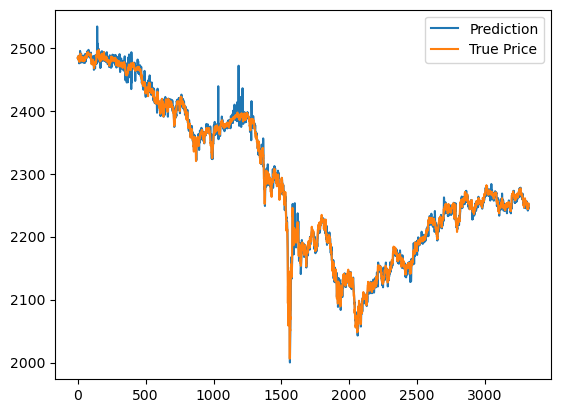

Computing for iteration -  3 ofi - True lvl - 10 window size 50


2024-12-08 15:48:10.414708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:48:10.934729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3502 - val_loss: 0.0066
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0275
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0663 - val_loss: 0.0168
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 - val_loss: 0.0028
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

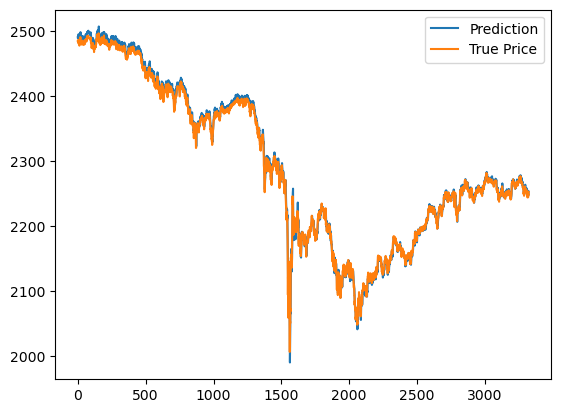

Computing for iteration -  2 ofi - True lvl - 10 window size 50


2024-12-08 15:48:42.867837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:48:43.492332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2193 - val_loss: 0.0074
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0519
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0589 - val_loss: 0.0235
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528 - val_loss: 0.0063
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0376
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0812 - val_loss: 0.0374
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0453 - val_loss: 0.0449
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1110 - val_loss: 0.0085
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266 - val_loss: 0.0062
Epoch 11/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

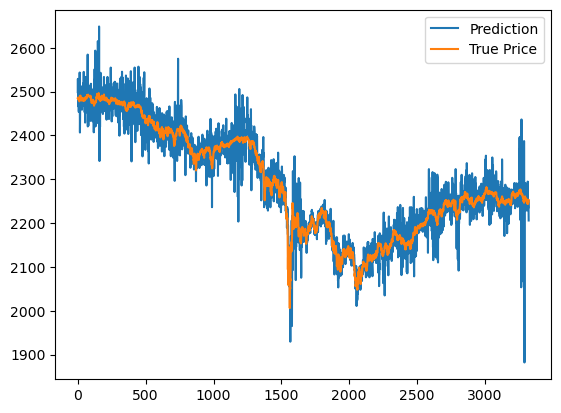

Computing for iteration -  1 ofi - True lvl - 10 window size 50


2024-12-08 15:49:15.289603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:49:15.779165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1173 - val_loss: 0.0026
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1917e-04 - val_loss: 0.0016
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1580e-04 - val_loss: 0.0014
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1136e-04 - val_loss: 0.0014
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4212e-04 - val_loss: 0.0015
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1208 - val_loss: 9.6905e-04
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8345e-04 - val_loss: 9.3971e-04
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1423e-04 - val_loss: 9.6297e-04
Epoch 9/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8736e-04 - val_loss: 0.0010
Epoch 10/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6052e-04 - val_loss: 9.5922e-04
Epoch 11/

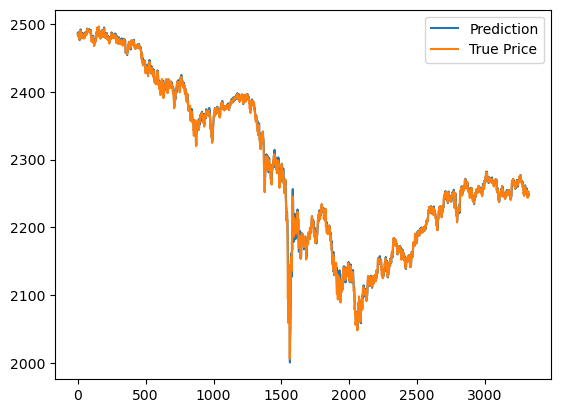

Computing for iteration -  3 ofi - False lvl - 3 window size 100


2024-12-08 15:49:46.692129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:49:46.967105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1109 - val_loss: 0.0137
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0125
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0139
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0130
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115 - val_loss: 0.0139
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - val_loss: 0.0127
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

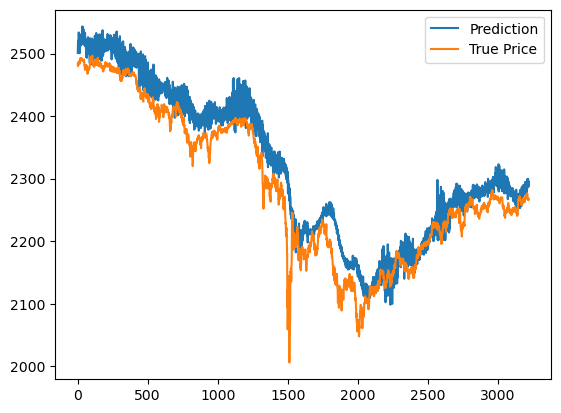

Computing for iteration -  2 ofi - False lvl - 3 window size 100


2024-12-08 15:50:15.849747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:50:16.127737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1148 - val_loss: 0.0155
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - val_loss: 0.0144
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - val_loss: 0.0175
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0203
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - val_loss: 0.0194
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - val_loss: 0.0133
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0190
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197 - val_loss: 0.0167
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0158
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 - val_loss: 0.0204
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

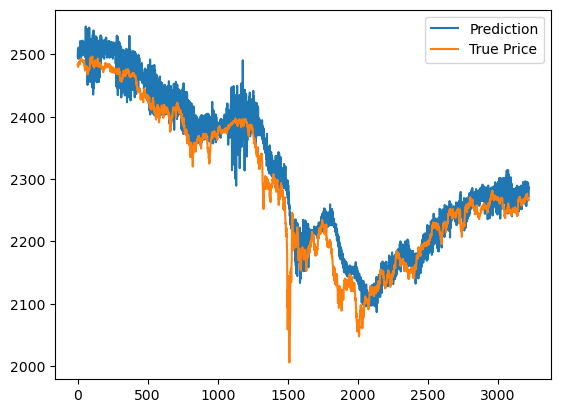

Computing for iteration -  1 ofi - False lvl - 3 window size 100


2024-12-08 15:50:44.401123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:50:44.718398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6690 - val_loss: 0.0289
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - val_loss: 0.0085
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0061
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0053
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

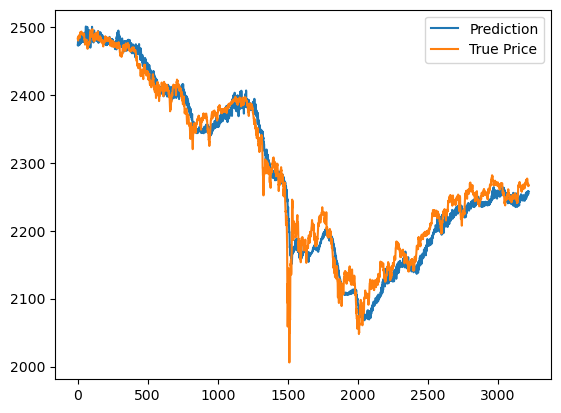

Computing for iteration -  3 ofi - True lvl - 3 window size 100


2024-12-08 15:51:15.042001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:51:15.838827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4467 - val_loss: 0.0209
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - val_loss: 0.0111
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0088
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - val_loss: 0.0070
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0069
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - val_loss: 0.0063
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - val_loss: 0.0075
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

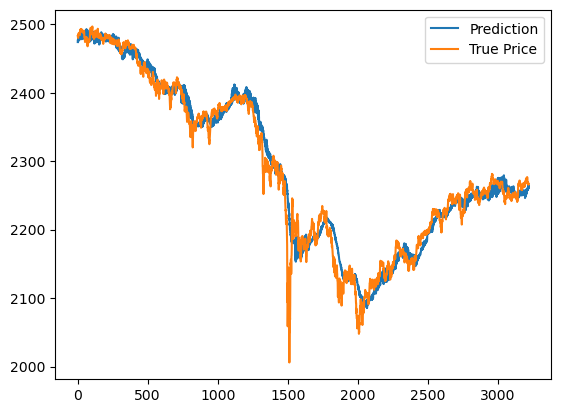

Computing for iteration -  2 ofi - True lvl - 3 window size 100


2024-12-08 15:51:48.388268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:51:48.712607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2749 - val_loss: 0.0159
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - val_loss: 0.0156
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180 - val_loss: 0.0175
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - val_loss: 0.0161
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0170
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0165
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

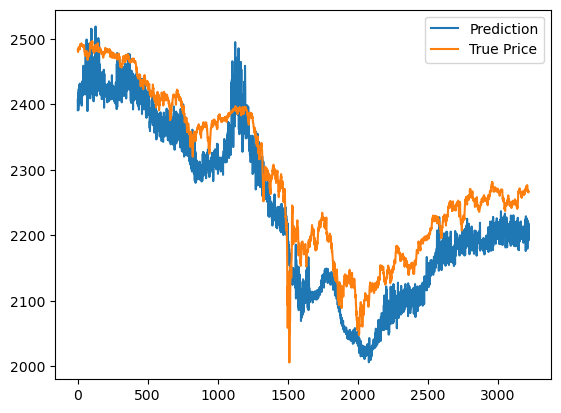

Computing for iteration -  1 ofi - True lvl - 3 window size 100


2024-12-08 15:52:19.894996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:52:20.241993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2629 - val_loss: 0.0093
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - val_loss: 0.0072
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0073
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - val_loss: 0.0072
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0049 - val_loss: 0.0069
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0083
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

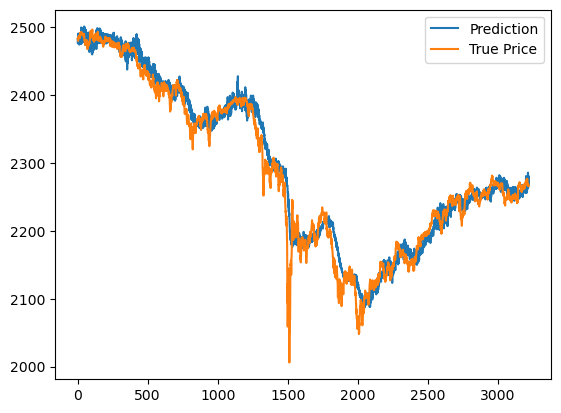

Computing for iteration -  3 ofi - False lvl - 5 window size 100


2024-12-08 15:52:51.525951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:52:51.943072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2286 - val_loss: 0.0075
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0122
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

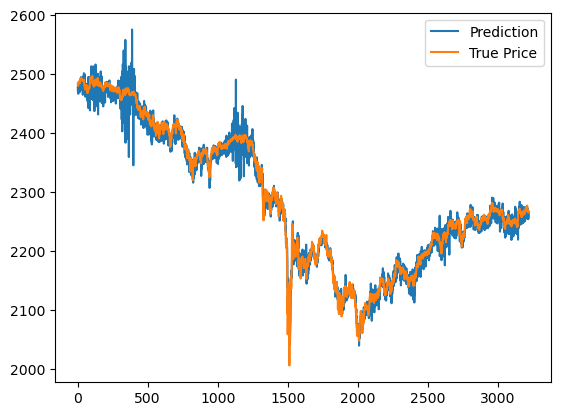

Computing for iteration -  2 ofi - False lvl - 5 window size 100


2024-12-08 15:53:22.824136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:53:23.196484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2247 - val_loss: 0.0355
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0776 - val_loss: 0.0235
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0457 - val_loss: 0.0159
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288 - val_loss: 0.0108
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0070
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

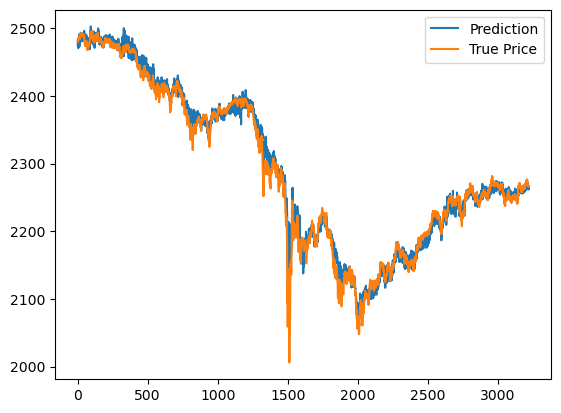

Computing for iteration -  1 ofi - False lvl - 5 window size 100


2024-12-08 15:53:55.715549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:53:56.134486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1155 - val_loss: 0.0071
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8408e-04 - val_loss: 0.0036
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

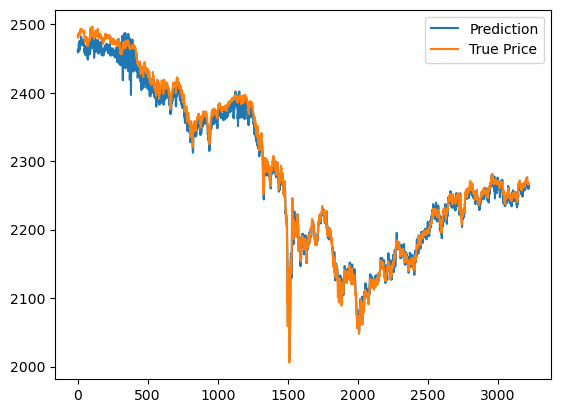

Computing for iteration -  3 ofi - True lvl - 5 window size 100


2024-12-08 15:54:27.362267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:54:27.884665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2081 - val_loss: 0.0076
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0056
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0052
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0053
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0075 - val_loss: 0.0052
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0111 - val_loss: 0.0540
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0602 - val_loss: 0.0032
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

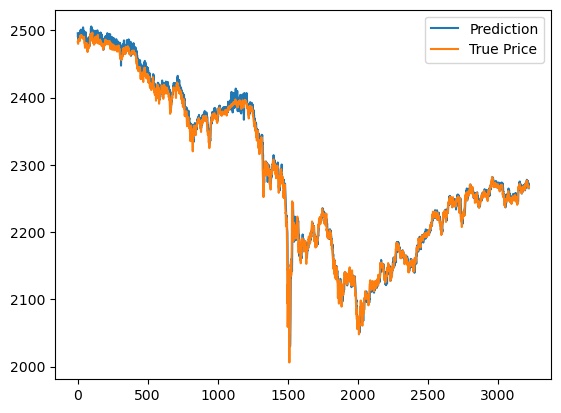

Computing for iteration -  2 ofi - True lvl - 5 window size 100


2024-12-08 15:54:58.967562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:54:59.470754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0722 - val_loss: 0.0068
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0083
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0131
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367 - val_loss: 0.0131
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0098
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

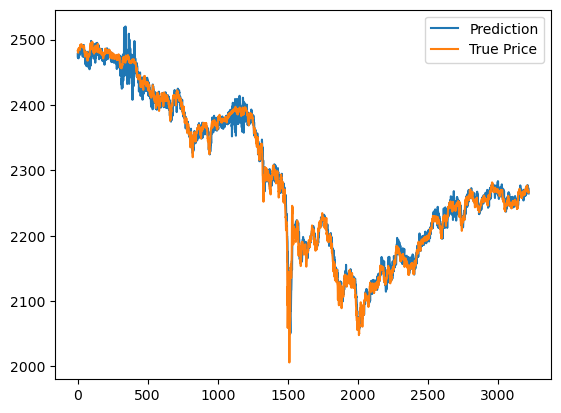

Computing for iteration -  1 ofi - True lvl - 5 window size 100


2024-12-08 15:55:28.564592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:55:28.998585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2284 - val_loss: 0.0097
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0063
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - val_loss: 0.0587
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - val_loss: 0.0024
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

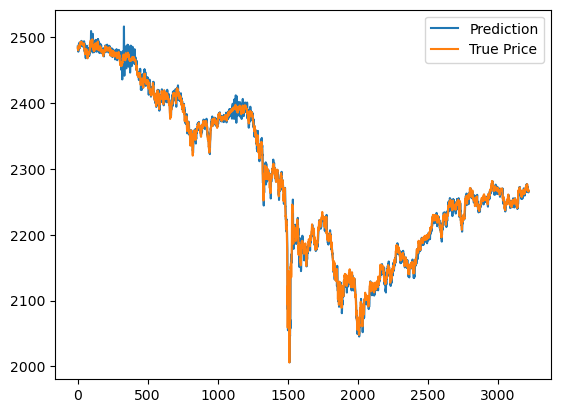

Computing for iteration -  3 ofi - False lvl - 10 window size 100


2024-12-08 15:55:58.274001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:55:59.292061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1508 - val_loss: 0.0081
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 0.0103
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.1010
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0894 - val_loss: 0.0094
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - val_loss: 0.0754
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1295 - val_loss: 0.0579
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0446 - val_loss: 0.0035
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

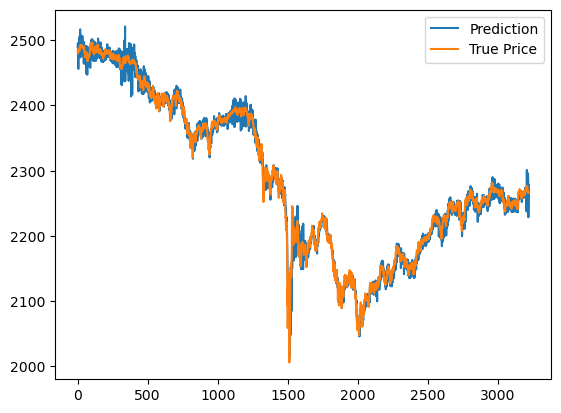

Computing for iteration -  2 ofi - False lvl - 10 window size 100


2024-12-08 15:56:34.338332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:56:35.369382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1306 - val_loss: 0.0253
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0400 - val_loss: 0.0439
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0430 - val_loss: 0.0106
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2745e-04 - val_loss: 0.0020
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3841e-04 - val_loss: 0.0026
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0671 - val_loss: 0.0884
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0985 - val_loss: 0.0285
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0330 - val_loss: 0.0278
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

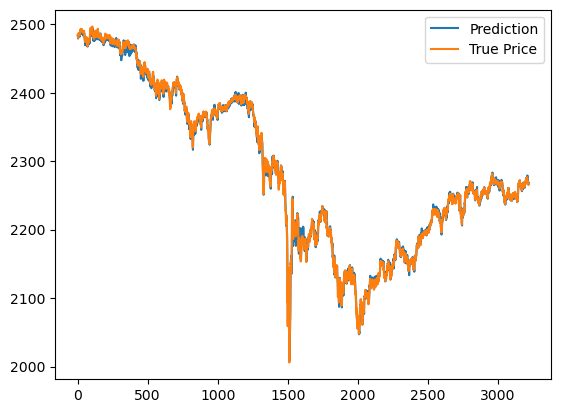

Computing for iteration -  1 ofi - False lvl - 10 window size 100


2024-12-08 15:57:11.931686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:57:12.616330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1342 - val_loss: 0.0095
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0159
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0305 - val_loss: 0.0729
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0994 - val_loss: 0.0067
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024 - val_loss: 0.0162
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0342 - val_loss: 0.0836
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

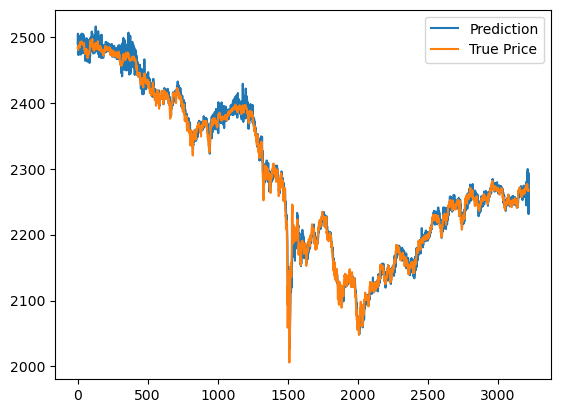

Computing for iteration -  3 ofi - True lvl - 10 window size 100


2024-12-08 15:57:50.496303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:57:51.702361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4966 - val_loss: 0.0544
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0803 - val_loss: 0.0601
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1117 - val_loss: 0.0585
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1325 - val_loss: 0.0847
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2297 - val_loss: 0.0659
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0917 - val_loss: 0.0695
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1088 - val_loss: 0.0765
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1199 - val_loss: 0.0816
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1146 - val_loss: 0.0573
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1279 - val_loss: 0.0808
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

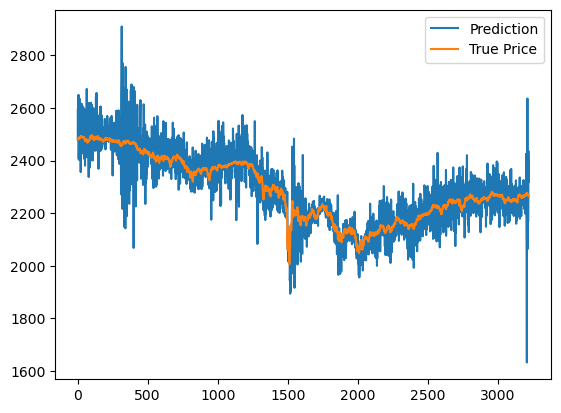

Computing for iteration -  2 ofi - True lvl - 10 window size 100


2024-12-08 15:58:28.373412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:58:29.525621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1341 - val_loss: 0.0508
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0630 - val_loss: 0.0417
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0531 - val_loss: 0.0412
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0798 - val_loss: 0.0159
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0515 - val_loss: 0.0510
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0705 - val_loss: 0.0630
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0576 - val_loss: 0.0405
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0587 - val_loss: 0.0410
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0621 - val_loss: 0.0585
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0908 - val_loss: 0.0145
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

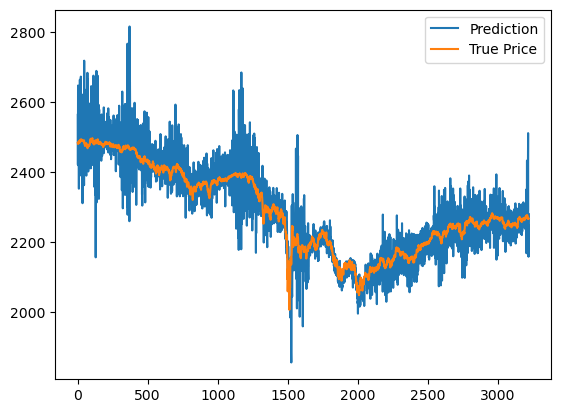

Computing for iteration -  1 ofi - True lvl - 10 window size 100


2024-12-08 15:59:11.826761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 15:59:13.685147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


425/425 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1117 - val_loss: 0.0109
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0168 - val_loss: 0.0331
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0485 - val_loss: 0.0267
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0320 - val_loss: 0.0306
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0551 - val_loss: 0.0224
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0391 - val_loss: 0.0187
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.0057
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - val_loss: 0.0062
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0086
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0374 - val_loss: 0.0406
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

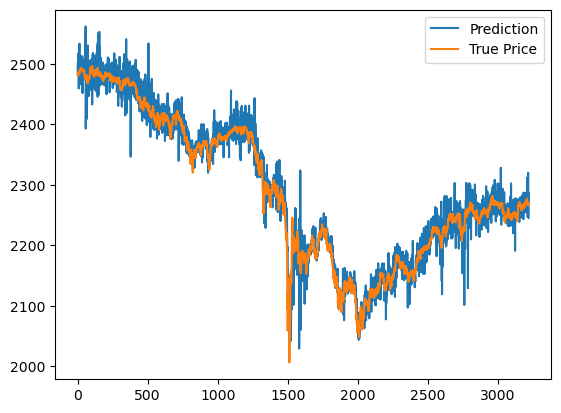

In [74]:
windows_size = [25, 50, 100]
lvls = [3, 5, 10]
ofi_lvls = [False, True]


window_size = 40


for window_size in windows_size:
    for lvl in lvls:
        for is_ofi in ofi_lvls:
            t = 3
            while t > 0:
                print("Computing for iteration - ", t, "ofi -", is_ofi, "lvl -", lvl, "window size" ,window_size)
                dp = DataPreprocess()
                
                df = dp.load_data(path)
                
                num_levels = lvl
                df = dp.get_bid_levels(df, num_levels)
                    
                if "time" in df.columns:
                    df = df.drop(columns=["time"])
                if is_ofi:
                    df = get_bid_with_ofi_levels(df, num_levels)
                    
                # Split dataset into train and test sets
                data_length = df.shape[0]
                train_length = round(0.8 * data_length)  # 80% training data
                normalized_df = normalize_data(df, train_length)
                
                data_array = normalized_df.to_numpy()
                
                X = data_array[:, 1:]  # All columns except the first ('midpoint')
                y = data_array[:, 0]   # The first column is 'midpoint'
                
                windows_train = timeseries_dataset_from_array(
                    X[:train_length],                    # Features for training
                    y[window_size:(train_length+window_size)],  # Target (midpoint) for training
                    sequence_length=window_size,        # Length of each input sequence
                    sequence_stride=1,                  # Step size for creating sequences
                    sampling_rate=1,                    # Sample every time step
                    batch_size=64,                      # Batch size
                    shuffle=False                        # Shuffle training data
                )
                
                # Windows for test dataset
                windows_test = timeseries_dataset_from_array(
                    X[train_length:(data_length-window_size)],  # Features for testing
                    y[train_length + window_size:],            # Target (midpoint) for testing
                    sequence_length=window_size,               # Length of each input sequence
                    sequence_stride=1,                         # Step size for creating sequences
                    sampling_rate=1,                           # Sample every time step
                    batch_size=64,                             # Batch size
                    shuffle=False                              # Do not shuffle test data
                )
                
                
                # Extract features and targets for training and testing
                X_train, y_train = extract_data_from_windows(windows_train)
                X_test, y_test = extract_data_from_windows(windows_test)
                
                X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten (num_samples, window_size, num_features) -> (num_samples, window_size*num_features)
                X_test_flat = X_test.reshape(X_test.shape[0], -1)
                # Initialize scaler
                scaler = StandardScaler()
                
                # Fit and transform training data
                X_train_scaled = scaler.fit_transform(X_train_flat)
                
                # Transform testing data
                X_test_scaled = scaler.transform(X_test_flat)
                
                X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
                X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
                
                
                input_layer = Input(shape = (X_train_scaled.shape[1], 1))
                conv_layer = Conv1D(filters = 1 , kernel_size = 10, strides = 10 , activation = 'linear')(input_layer)
                conv_layer = Conv1D(filters= 1, kernel_size = 10, padding='same', activation='linear')(conv_layer)
                flatten_layer = Flatten()(conv_layer)
                full_model = Model(inputs = input_layer, outputs = flatten_layer)
                
                X_train_features = full_model.predict(X_train_scaled)
                X_test_features = full_model.predict(X_test_scaled)
                
                
                # Input dimensions are based on the embedding size
                input_dim = X_train_features.shape[1]
                
                # Define the SVR-like model
                svr_input = Input(shape=(input_dim,))
                svr_output = Dense(1, activation='linear')(svr_input)
                
                svr_model = Model(inputs=svr_input, outputs=svr_output)
                
                # Compile the model with the custom loss function
                svr_model.compile(optimizer=Adam(learning_rate=0.01),
                                  loss=lambda y_true, y_pred: custom_svr_loss(y_true, y_pred, epsilon= 0.98 , mu= 0.98))
                
                history_svr = svr_model.fit(
                    X_train_features, y_train,  # Training embeddings and targets
                    validation_data=(X_test_features, y_test),  # Validation embeddings and targets
                    epochs=50,  # Number of epochs
                    batch_size=64,  # Batch size
                    verbose=1  # Verbosity level
                )
                
                calculate_metrics_and_plot(svr_model, num_levels)
                t-=1

In [298]:
from sklearn.svm import SVR

# Initialize SVR with RBF kernel
svr_original = SVR(kernel='rbf', C=0.1, epsilon=0.1)

# Train the SVR model
svr_original.fit(X_train_features, y_train)

SVR(C=0.1)

In [299]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = svr_original.predict(X_test_features)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.012304598786770149
R² Score: 0.9785457271129681


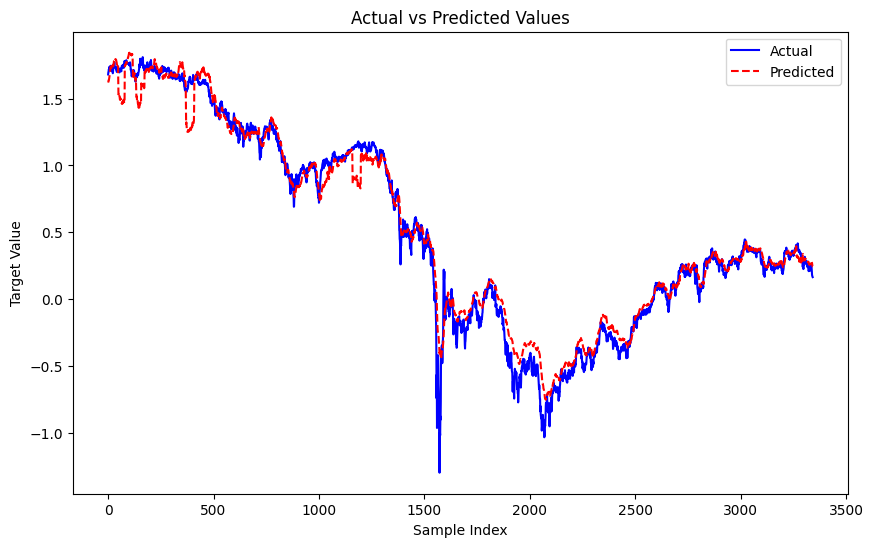

In [300]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
plt.legend()
plt.title("Actual vs Predicted Values")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.show()